THIS NOTEBOOK IS TO PREDICT IF COUNTRY'S ECONIMICAL FACTOR HELP COUNTRIES TO WIN LOW,MEDIUM OR HIGH NUMBER OF MEDALS.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import OrdinalClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve, classification_report, precision_recall_curve

Reading  Events and regions file and merging them

In [2]:
events=pd.read_csv("/home/jovyan/athlete_events.csv") 
regions=pd.read_csv("/home/jovyan/noc_regions.csv")
olympics = pd.merge(events, regions, on="NOC", how="left") 
print(olympics.head(),olympics.shape)

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal       region notes  
0       Basketball Men's Basketball   NaN        China   NaN  
1      Judo Men's Extra-Lightwei

Filtering the Dataset to include only Summer data

In [3]:
Summer_olympics=olympics[(olympics.Season=='Summer') & (olympics.Year!=1906)]

Now preparing the Dataset to merge with GDP and Population data 

In [4]:
## filling the NaN values of column 'Region' by taking the values from 'Team' 
Summer_olympics["region"].fillna(Summer_olympics["Team"], inplace=True)
Summer_olympics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 271110
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      220819 non-null  int64  
 1   Name    220819 non-null  object 
 2   Sex     220819 non-null  object 
 3   Age     212373 non-null  float64
 4   Height  170438 non-null  float64
 5   Weight  168493 non-null  float64
 6   Team    220819 non-null  object 
 7   NOC     220819 non-null  object 
 8   Games   220819 non-null  object 
 9   Year    220819 non-null  int64  
 10  Season  220819 non-null  object 
 11  City    220819 non-null  object 
 12  Sport   220819 non-null  object 
 13  Event   220819 non-null  object 
 14  Medal   33630 non-null   object 
 15  region  220819 non-null  object 
 16  notes   4361 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 30.3+ MB


Just selecting the required columns now

In [5]:
Summer_olympics = Summer_olympics[["NOC","Sex","Year", "City", "Medal","region"]]
Summer_olympics.head()


,NOC,Sex,Year,City,Medal,region
0,CHN,M,1992,Barcelona,NaN,China
1,CHN,M,2012,London,NaN,China
2,DEN,M,1920,Antwerpen,NaN,Denmark
3,DEN,M,1900,Paris,Gold,Denmark
26,NED,F,1932,Los Angeles,NaN,Netherlands


In [6]:
#change faulty country code values.
faulty_codes_dict = {"MAS": "MAL", "NBO": "MAL",
                    "TCH": "CZE",
                    "YUG": "SRB", "SCG": "SRB",
                    "TTO": "TRI", "WIF": "TRI",
                    "SAA": "GER", "GDR": "GER",
                    "URS": "RUS", "EUN": "RUS",
                    "VNM": "VIE",
                    "RHO": "ZIM",
                    "UAR": "SYR",
                    "YAR": "YEM", "YMD": "YEM",
                    "SSD": "SUD"}

Summer_olympics = Summer_olympics.replace(to_replace = faulty_codes_dict)

#sort by year and country
Summer_olympics = Summer_olympics.sort_values(by = ["Year", "NOC"])
Summer_olympics = Summer_olympics.reset_index(drop = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,NaN,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,NaN,Australia


Check if there are any null values in the columns

In [7]:
Summer_olympics.isnull().any()

NOC       False
Sex       False
Year      False
City      False
Medal      True
region    False
dtype: bool

Medal column has null values. We will be replacing it with the value 0

In [8]:
Summer_olympics["Medal"].fillna(value = 0, inplace = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,0,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,0,Australia


Sorting the dataset by Year and then NOC

In [9]:
#sort by year and country
Summer_olympics = Summer_olympics.sort_values(by = ["Year", "NOC"])
Summer_olympics = Summer_olympics.reset_index(drop = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,0,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,0,Australia


Creating a new column for total participation 

In [10]:
## participation by country
participants_count=Summer_olympics.groupby(['Year','NOC'])["NOC"].count().reset_index(name="Total Participants")
participants_count.head()


## merging this with our main data set calledSummer_olympics
Summer_olympics = pd.merge(Summer_olympics,participants_count,on=['NOC','Year'],how="left")
Summer_olympics.head(10)

,NOC,Sex,Year,City,Medal,region,Total Participants
0,AUS,M,1896,Athina,0,Australia,5
1,AUS,M,1896,Athina,Bronze,Australia,5
2,AUS,M,1896,Athina,Gold,Australia,5
3,AUS,M,1896,Athina,Gold,Australia,5
4,AUS,M,1896,Athina,0,Australia,5
5,AUT,M,1896,Athina,Silver,Austria,8
6,AUT,M,1896,Athina,Gold,Austria,8
7,AUT,M,1896,Athina,0,Austria,8
8,AUT,M,1896,Athina,Bronze,Austria,8
9,AUT,M,1896,Athina,0,Austria,8


Medal Tally: Medal tally is the sum of all medals won.

In [11]:
# creating  new df medal
medal = Summer_olympics.groupby(['Year','NOC','Medal']).size().unstack('Medal',fill_value=0)
medal['Total Medal'] = medal['Gold'] +medal['Silver'] +medal['Bronze'] 
medal

# merging this with our main data set called olympics_complete
Summer_olympics = pd.merge(Summer_olympics,medal,on=['NOC','Year'],how="left")
Summer_olympics.head()



,NOC,Sex,Year,City,Medal,region,Total Participants,0,Bronze,Gold,Silver,Total Medal
0,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3
1,AUS,M,1896,Athina,Bronze,Australia,5,2,1,2,0,3
2,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3
3,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3
4,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3


ALSO LETS CREATE NEW COLUMNS TO CAPTURE HOW MANY MALE AND FEMALE PARTIPATES FROM THESE COUNTRIES EVRY YEAR

In [12]:
#total Male participation and Female participation column
Gender = Summer_olympics.groupby(['Year','NOC','Sex']).size().unstack('Sex',fill_value=0)
Gender.rename(columns ={"F": "Female", "M": "Male"},inplace = True)
Gender
# merging this with our main data set called olympics_complete
Summer_olympics = pd.merge(Summer_olympics,Gender,on=['NOC','Year'],how="left")
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region,Total Participants,0,Bronze,Gold,Silver,Total Medal,Female,Male
0,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3,0,5
1,AUS,M,1896,Athina,Bronze,Australia,5,2,1,2,0,3,0,5
2,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3,0,5
3,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3,0,5
4,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3,0,5


In [13]:
Summer_olympics = Summer_olympics[["NOC","Year","City","region","Total Participants","Bronze","Gold","Silver","Total Medal","Female","Male"]]

In [14]:
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 220818
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   NOC                 220819 non-null  object
 1   Year                220819 non-null  int64 
 2   City                220819 non-null  object
 3   region              220819 non-null  object
 4   Total Participants  220819 non-null  int64 
 5   Bronze              220819 non-null  int64 
 6   Gold                220819 non-null  int64 
 7   Silver              220819 non-null  int64 
 8   Total Medal         220819 non-null  int64 
 9   Female              220819 non-null  int64 
 10  Male                220819 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 20.2+ MB


Once we have the toal participation, lets remove the duplicate rows.

In [15]:
Summer_olympics= Summer_olympics.drop_duplicates()
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813 entries, 0 to 220788
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NOC                 2813 non-null   object
 1   Year                2813 non-null   int64 
 2   City                2813 non-null   object
 3   region              2813 non-null   object
 4   Total Participants  2813 non-null   int64 
 5   Bronze              2813 non-null   int64 
 6   Gold                2813 non-null   int64 
 7   Silver              2813 non-null   int64 
 8   Total Medal         2813 non-null   int64 
 9   Female              2813 non-null   int64 
 10  Male                2813 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 263.7+ KB


AS WE ARE TRYING TO SEE WHICH CATEGORY (LOW,MEDIUM or HIGH) A COUNTRY FALLS INTO, LEST ONLY CONSIDER THE COUNTRIES WHO HAVE WON MEDALS AND REMOVE THOSE WHO HAVE ZERO MEDALS.

In [16]:
# lets consider only those countries who have won the medals
Summer_olympics = Summer_olympics[(Summer_olympics['Total Medal']!=0)]
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 0 to 220746
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NOC                 1280 non-null   object
 1   Year                1280 non-null   int64 
 2   City                1280 non-null   object
 3   region              1280 non-null   object
 4   Total Participants  1280 non-null   int64 
 5   Bronze              1280 non-null   int64 
 6   Gold                1280 non-null   int64 
 7   Silver              1280 non-null   int64 
 8   Total Medal         1280 non-null   int64 
 9   Female              1280 non-null   int64 
 10  Male                1280 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 120.0+ KB


Lets Merge this data with population and GDP

In [17]:
#Reading GDP data
#The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient merging.
w_gdp = pd.read_csv("/home/jovyan/world_gdp.csv", skiprows = 3)
# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [18]:
print(w_gdp.isnull().sum())

Country Name       0
Country Code       0
Year               0
GDP             3225
dtype: int64


In [19]:
sort = w_gdp.sort_values(['Year'])
sort.head(10)

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
140,Netherlands,NLD,1960,1.227673e+10
141,New Caledonia,NCL,1960,NaN
142,New Zealand,NZL,1960,5.485855e+09
143,Nicaragua,NIC,1960,NaN
144,Niger,NER,1960,4.495269e+08
145,Nigeria,NGA,1960,4.196092e+09
146,Northern Mariana Islands,MNP,1960,NaN
147,Norway,NOR,1960,5.163272e+09
148,Not classified,INX,1960,NaN


In [20]:
# as the GDP data is from 1960, lets first consider only the data from 1960 for olympics
Summer_olympics=Summer_olympics[Summer_olympics.Year >= 1960]
Summer_olympics.head()

,NOC,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male
54573,ARG,1960,Roma,Argentina,116,1,0,3,4,1,115
54689,AUS,1960,Roma,Australia,280,11,11,24,46,56,224
54969,AUT,1960,Roma,Austria,198,0,1,2,3,54,144
55181,BEL,1960,Roma,Belgium,150,2,0,2,4,20,130
55340,BRA,1960,Roma,Brazil,86,13,0,0,13,1,85


In [21]:
#lets check if we need to merge using the column country code. All NOC in Summer Olympics data is not present in GDP data.
len(list(set(olympics['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [22]:
# as All the NOC in the Summer Olympics dataset is not present in the country code in the GDP data,lets merge using Team name in Summer Olympics dataset
# and country name in GDP data. 
olympics_merge_ccode = pd.merge(Summer_olympics, w_gdp[['Country Name', 'Country Code']].drop_duplicates(), left_on=['region'],right_on=['Country Name'], how="left")


olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)
olympics_merge_ccode.head()

olympics_merge_gdp = pd.merge(olympics_merge_ccode, w_gdp, on=['Country Code', 'Year'], how="left")

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)
olympics_merge_gdp.head()

,NOC,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male,Country Code,GDP
0,ARG,1960,Roma,Argentina,116,1,0,3,4,1,115,ARG,NaN
1,AUS,1960,Roma,Australia,280,11,11,24,46,56,224,AUS,1.859335e+10
2,AUT,1960,Roma,Austria,198,0,1,2,3,54,144,AUT,6.592694e+09
3,BEL,1960,Roma,Belgium,150,2,0,2,4,20,130,BEL,1.165872e+10
4,BRA,1960,Roma,Brazil,86,13,0,0,13,1,85,BRA,1.516557e+10


Now just lets drop the column NOC as we will be using Country Code for further processing

In [23]:
olympics_merge_gdp= olympics_merge_gdp[["Year","City","region","Total Participants","Bronze","Gold","Silver","Total Medal","Female","Male","Country Code","GDP"]]

In [24]:
#Apart from GDP, population is also of importance when looking at a countries performance as 
#Higher populations mean a bigger talent pool to choose from

w_pop = pd.read_csv('/home/jovyan/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [25]:
#merge the Population data
olympics_complete = pd.merge(olympics_merge_gdp, w_pop, on=['Country Code', 'Year'], how="left")
olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()


,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male,Country Code,GDP,Population
0,1960,Roma,Argentina,116,1,0,3,4,1,115,ARG,NaN,20619075.0
1,1960,Roma,Australia,280,11,11,24,46,56,224,AUS,1.859335e+10,10276477.0
2,1960,Roma,Austria,198,0,1,2,3,54,144,AUT,6.592694e+09,7047539.0
3,1960,Roma,Belgium,150,2,0,2,4,20,130,BEL,1.165872e+10,9153489.0
4,1960,Roma,Brazil,86,13,0,0,13,1,85,BRA,1.516557e+10,72207554.0


In [26]:
#lets look for the unique city name
olympics_complete[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
0,1960,Roma
45,1964,Tokyo
86,1968,Mexico City
130,1972,Munich
178,1976,Montreal
219,1980,Moskva
255,1984,Los Angeles
302,1988,Seoul
354,1992,Barcelona
418,1996,Atlanta


In [27]:
#correcting Host City's Name 
olympics_complete['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [28]:
# city to country mapping dictionary
city_to_country = {'Roma': 'Italy',
                   'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Creating a new column called Country_Host by mapping the cities to CountryMap cities to countries
olympics_complete['Country_Host'] = olympics_complete['City'].map(city_to_country)

#print the 
olympics_complete.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')
olympics_complete.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 0 to 907
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                908 non-null    int64  
 1   City                908 non-null    object 
 2   region              908 non-null    object 
 3   Total Participants  908 non-null    int64  
 4   Bronze              908 non-null    int64  
 5   Gold                908 non-null    int64  
 6   Silver              908 non-null    int64  
 7   Total Medal         908 non-null    int64  
 8   Female              908 non-null    int64  
 9   Male                908 non-null    int64  
 10  Country Code        895 non-null    object 
 11  GDP                 805 non-null    float64
 12  Population          886 non-null    float64
 13  Country_Host        908 non-null    object 
dtypes: float64(2), int64(8), object(4)
memory usage: 106.4+ KB


In [29]:
#Lets sort the dataset by year and Country
olympics_complete = olympics_complete.sort_values(by = ["Year", "Country Code"])
olympics_complete = olympics_complete.reset_index(drop = True)
olympics_complete.head()
                                                                                                                                                               

,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male,Country Code,GDP,Population,Country_Host
0,1960,Roma,Argentina,116,1,0,3,4,1,115,ARG,NaN,20619075.0,Italy
1,1960,Roma,Australia,280,11,11,24,46,56,224,AUS,1.859335e+10,10276477.0,Italy
2,1960,Roma,Austria,198,0,1,2,3,54,144,AUT,6.592694e+09,7047539.0,Italy
3,1960,Roma,Belgium,150,2,0,2,4,20,130,BEL,1.165872e+10,9153489.0,Italy
4,1960,Roma,Bulgaria,183,3,1,3,7,40,143,BGR,NaN,7867374.0,Italy


In [30]:
## lets put Host value as 1 if the region is same as host country or else 0
olympics_complete.loc[olympics_complete['region'] == olympics_complete['Country_Host'], 'Host'] = 1 
olympics_complete.loc[olympics_complete['region'] != olympics_complete['Country_Host'], 'Host'] = 0
olympics_complete.head()


,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male,Country Code,GDP,Population,Country_Host,Host
0,1960,Roma,Argentina,116,1,0,3,4,1,115,ARG,NaN,20619075.0,Italy,0.0
1,1960,Roma,Australia,280,11,11,24,46,56,224,AUS,1.859335e+10,10276477.0,Italy,0.0
2,1960,Roma,Austria,198,0,1,2,3,54,144,AUT,6.592694e+09,7047539.0,Italy,0.0
3,1960,Roma,Belgium,150,2,0,2,4,20,130,BEL,1.165872e+10,9153489.0,Italy,0.0
4,1960,Roma,Bulgaria,183,3,1,3,7,40,143,BGR,NaN,7867374.0,Italy,0.0


NOW lets convert the 'Total Medal' values into Categorical Values

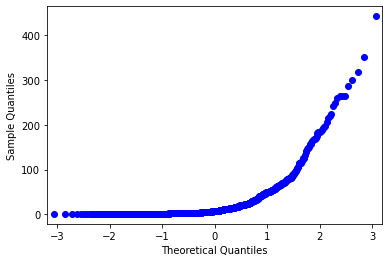

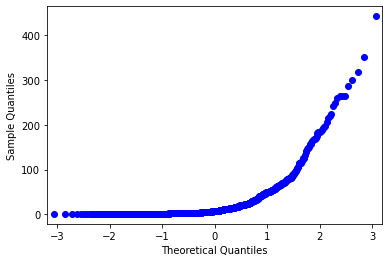

In [31]:
#we should consider distribution of data prior to deciding bin size
from statsmodels.graphics.gofplots import qqplot
qqplot(olympics_complete['Total Medal'])

In [32]:
pd.qcut(olympics_complete['Total Medal'], q=5)

0         (2.0, 5.0]
1      (38.6, 442.0]
2         (2.0, 5.0]
3         (2.0, 5.0]
4        (5.0, 13.0]
           ...      
903     (0.999, 2.0]
904     (0.999, 2.0]
905     (13.0, 38.6]
906     (0.999, 2.0]
907       (2.0, 5.0]
Name: Total Medal, Length: 908, dtype: category
Categories (5, interval[float64]): [(0.999, 2.0] < (2.0, 5.0] < (5.0, 13.0] < (13.0, 38.6] < (38.6, 442.0]]

In [33]:
## Binning the orignial dataset into 5 categorical values: 1 would be high category and 5 the lowest

#olympics_complete['Medal category'] = pd.qcut(olympics_complete['Total Medal'], q=5,labels=["very low", "low", "medium","high","very high"])
olympics_complete['Medal category'] = pd.qcut(olympics_complete['Total Medal'], q=5,labels=["5", "4", "3","2","1"])
      
    
olympics_complete.head()

,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Female,Male,Country Code,GDP,Population,Country_Host,Host,Medal category
0,1960,Roma,Argentina,116,1,0,3,4,1,115,ARG,NaN,20619075.0,Italy,0.0,4
1,1960,Roma,Australia,280,11,11,24,46,56,224,AUS,1.859335e+10,10276477.0,Italy,0.0,1
2,1960,Roma,Austria,198,0,1,2,3,54,144,AUT,6.592694e+09,7047539.0,Italy,0.0,4
3,1960,Roma,Belgium,150,2,0,2,4,20,130,BEL,1.165872e+10,9153489.0,Italy,0.0,4
4,1960,Roma,Bulgaria,183,3,1,3,7,40,143,BGR,NaN,7867374.0,Italy,0.0,3


LETS CLEAN THE DATA LITTLE MORE BEFORE WE DO THE SPLITTING

In [34]:
olympics_complete = olympics_complete[["Year","Total Participants","Total Medal","Female","Male","Country Code","GDP","Population","Host","Medal category"]]
olympics_complete.head()

,Year,Total Participants,Total Medal,Female,Male,Country Code,GDP,Population,Host,Medal category
0,1960,116,4,1,115,ARG,NaN,20619075.0,0.0,4
1,1960,280,46,56,224,AUS,1.859335e+10,10276477.0,0.0,1
2,1960,198,3,54,144,AUT,6.592694e+09,7047539.0,0.0,4
3,1960,150,4,20,130,BEL,1.165872e+10,9153489.0,0.0,4
4,1960,183,7,40,143,BGR,NaN,7867374.0,0.0,3


DATASET IS NOW READY. LETS SPLIT THE DATA INTO TRAINING AND TEST SET

In [35]:
data_train = olympics_complete[olympics_complete.Year<2016].reset_index(drop = True)
data_test = olympics_complete[olympics_complete.Year==2016].reset_index(drop = True)

In [36]:
#Lets Impute the missing value of Column GDP and Population of training set
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Year                822 non-null    int64   
 1   Total Participants  822 non-null    int64   
 2   Total Medal         822 non-null    int64   
 3   Female              822 non-null    int64   
 4   Male                822 non-null    int64   
 5   Country Code        811 non-null    object  
 6   GDP                 725 non-null    float64 
 7   Population          802 non-null    float64 
 8   Host                822 non-null    float64 
 9   Medal category      822 non-null    category
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 58.9+ KB


In [37]:
print(data_train[['GDP','Population']].skew())

GDP           7.039156
Population    5.855652
dtype: float64


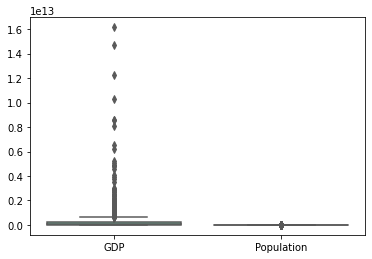

In [38]:
## box Plot
import seaborn as sns
ax = sns.boxplot(data=data_train.iloc[:,6:8],orient="v", palette="Set2")

DATA IMPUTATION : GDP AND POPULATION

In [39]:
#Fill in the NaN values for GDP and Population Size, with the median values of the entire column (as we find the data highly skewed)
import numpy as np
imp_col = ['GDP','Population']
for col in imp_col:
    data_train.loc[:,(col)] = data_train.loc[:,(col)].fillna((data_train.loc[:,(col)].median()))

 #data_train.loc[:,(target)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Year                822 non-null    int64   
 1   Total Participants  822 non-null    int64   
 2   Total Medal         822 non-null    int64   
 3   Female              822 non-null    int64   
 4   Male                822 non-null    int64   
 5   Country Code        811 non-null    object  
 6   GDP                 822 non-null    float64 
 7   Population          822 non-null    float64 
 8   Host                822 non-null    float64 
 9   Medal category      822 non-null    category
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 58.9+ KB


GDP PER CAPITA: Creating a new column called GDP per capita by diving GDP with Population as Its not GDP alone but GDP per capita decides how much resources a country has and its a good predictor value than GDP alone

In [40]:
data_train['GDP Per Capita'] = data_train['GDP']/data_train['Population']
data_train.head()

,Year,Total Participants,Total Medal,Female,Male,Country Code,GDP,Population,Host,Medal category,GDP Per Capita
0,1960,116,4,1,115,ARG,6.076348e+10,20619075.0,0.0,4,2946.954854
1,1960,280,46,56,224,AUS,1.859335e+10,10276477.0,0.0,1,1809.311452
2,1960,198,3,54,144,AUT,6.592694e+09,7047539.0,0.0,4,935.460427
3,1960,150,4,20,130,BEL,1.165872e+10,9153489.0,0.0,4,1273.691659
4,1960,183,7,40,143,BGR,6.076348e+10,7867374.0,0.0,3,7723.477128


In [41]:
predictors = ["Year","Total Participants","Female","Male","GDP","Population","Host","GDP Per Capita"]
X_train = data_train.loc[:,(predictors)].reset_index(drop = True)
Y_train=data_train['Medal category']
print (X_train,Y_train)

     Year  Total Participants  Female  Male           GDP    Population  Host  \
0    1960                 116       1   115  6.076348e+10  2.061908e+07   0.0   
1    1960                 280      56   224  1.859335e+10  1.027648e+07   0.0   
2    1960                 198      54   144  6.592694e+09  7.047539e+06   0.0   
3    1960                 150      20   130  1.165872e+10  9.153489e+06   0.0   
4    1960                 183      40   143  6.076348e+10  7.867374e+06   0.0   
..    ...                 ...     ...   ...           ...           ...   ...   
817  2012                 689     343   346  1.615530e+13  3.139984e+08   0.0   
818  2012                  56      19    37  5.182157e+10  2.977450e+07   0.0   
819  2012                  85      36    49  3.812860e+11  2.989308e+07   0.0   
820  2012                 145      61    84  3.963330e+11  5.250652e+07   0.0   
821  2012                  55      33    22  6.076348e+10  1.527264e+07   0.0   

     GDP Per Capita  
0    

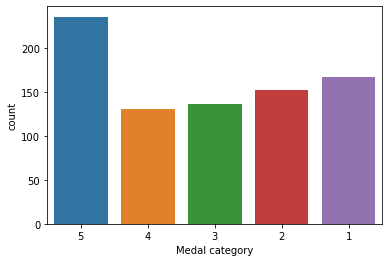

In [42]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(['5','4','3','2','1'])
plt.show()

In [43]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=20))
embeded_rf_selector.fit(X_train,Y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

6 selected features
['Total Participants', 'Female', 'Male', 'GDP', 'Population', 'GDP Per Capita']


In [44]:
##Feature Selection: Recursive Feature Elimination
X_norm = MinMaxScaler().fit_transform(X_train)
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X_norm, Y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 8 features.
5 selected features
['Total Participants', 'Female', 'Male', 'GDP', 'Population']


Lets build and train the Model
1)RandomForest Classifier

In [46]:
# Create Random Forest Classifier object
clf = RandomForestClassifier(max_depth=2, random_state=10)


Generating an Year list to run Timseseries Cross Validation

In [47]:
year_list = data_train['Year'].unique()
print(year_list)

[1960 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008 2012]


In [48]:
## assessing performance of the model using timeseries cross validation
#tscv1=TimeSeriesSplit(n_splits=5,test_size=None).split(year_list)
tscv=TimeSeriesSplit(n_splits=5,max_train_size=None,test_size=2).split(year_list)
scores_clf =cross_val_score(clf,X_train[['Total Participants', 'Female', 'Male', 'GDP', 'Population','Year']],Y_train, cv=tscv)
print(scores_clf)
print("Average Accuracy of random forest model across the timeseries folds: %0.2f" % (scores_clf.mean()))

## assessing performance of the model using 5 fold cross validation
scores_clf1 = cross_val_score(clf, X_train[['Total Participants', 'Female', 'Male', 'GDP', 'Population']], Y_train, cv=5 )
scores_clf1
print("Average Accuracy of random forest model across the folds: %0.2f" % (scores_clf1.mean()))

[0.  0.  0.5 0.  0. ]
Average Accuracy of random forest model across the timeseries folds: 0.10
Average Accuracy of random forest model across the folds: 0.53


OBSERVATION: CROSS FOLD VALIDATION WORKS BETTER THAN TIMESERIES

In [49]:
#Fitting
clf.fit(X_train[['Total Participants', 'Female', 'Male', 'GDP', 'Population']], Y_train)

RandomForestClassifier(max_depth=2, random_state=10)

PREPARING TEST DATA: Before we Predict lets prepare the Test data first, as I do not want to make any assumptional changes or imputaion, lets drop all the rows in test data which is empty.

In [50]:
data_test = data_test.dropna()
data_test.info()
#create a new cloumn called GDP per Capita
data_test['GDP Per Capita'] = data_test['GDP']/data_test['Population']
data_test.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 83
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Year                80 non-null     int64   
 1   Total Participants  80 non-null     int64   
 2   Total Medal         80 non-null     int64   
 3   Female              80 non-null     int64   
 4   Male                80 non-null     int64   
 5   Country Code        80 non-null     object  
 6   GDP                 80 non-null     float64 
 7   Population          80 non-null     float64 
 8   Host                80 non-null     float64 
 9   Medal category      80 non-null     category
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 6.5+ KB


,Year,Total Participants,Total Medal,Female,Male,Country Code,GDP,Population,Host,Medal category,GDP Per Capita
0,2016,12,1,3,9,ARE,3.487430e+11,9269612.0,0.0,5,37622.178792
1,2016,232,22,82,150,ARG,5.454760e+11,43847430.0,0.0,2,12440.318623
2,2016,34,4,10,24,ARM,1.057230e+10,2924816.0,0.0,4,3614.688357
3,2016,518,82,263,255,AUS,1.204620e+12,24127159.0,0.0,1,49927.967068
4,2016,85,2,40,45,AUT,3.908000e+11,8747358.0,0.0,5,44676.346847
5,2016,69,18,16,53,AZE,3.784772e+10,9762274.0,0.0,2,3876.936433
6,2016,10,1,4,6,BDI,3.007029e+09,10524117.0,0.0,5,285.727442
7,2016,138,21,53,85,BEL,4.679560e+11,11348159.0,0.0,2,41236.292160
8,2016,58,7,25,33,BGR,5.323788e+10,7127822.0,0.0,3,7469.025247
9,2016,33,2,13,20,BHR,3.217907e+10,1425171.0,0.0,5,22579.093420


In [51]:
predictors = ['Total Participants', 'Female', 'Male', 'GDP', 'Population']
X_test = data_test.loc[:,(predictors)].reset_index(drop = True)
Y_test = data_test['Medal category']
print (X_test,Y_test)

    Total Participants  Female  Male           GDP   Population
0                   12       3     9  3.487430e+11    9269612.0
1                  232      82   150  5.454760e+11   43847430.0
2                   34      10    24  1.057230e+10    2924816.0
3                  518     263   255  1.204620e+12   24127159.0
4                   85      40    45  3.908000e+11    8747358.0
..                 ...     ...   ...           ...          ...
75                 719     369   350  1.862450e+13  323127513.0
76                  80      27    53  6.722034e+10   31848200.0
77                  28      16    12  2.052760e+11   92701100.0
78                   8       5     3  6.649889e+09    1816200.0
79                 155      46   109  2.954560e+11   55908865.0

[80 rows x 5 columns] 0     5
1     2
2     4
3     1
4     5
     ..
78    1
79    3
81    5
82    5
83    2
Name: Medal category, Length: 80, dtype: category
Categories (5, object): [5 < 4 < 3 < 2 < 1]


PREDICTION

In [52]:
#Now lets predict
y_predictions = clf.predict(X_test)
print(y_predictions)

['5' '1' '5' '1' '5' '5' '5' '3' '5' '5' '5' '2' '1' '1' '2' '1' '5' '2'
 '2' '1' '2' '5' '5' '3' '1' '5' '5' '5' '5' '1' '1' '5' '3' '5' '3' '2'
 '5' '3' '5' '5' '5' '1' '5' '5' '1' '2' '5' '1' '5' '5' '3' '5' '5' '5'
 '5' '1' '5' '2' '5' '1' '3' '5' '2' '1' '5' '2' '5' '5' '1' '5' '5' '5'
 '5' '3' '1' '1' '5' '5' '5' '3']


In [53]:
print("accuracy of the predictions using RandomForest CLF:", metrics.accuracy_score(Y_test, y_predictions))
print("blanced accuracy of the predictions using RandomForest CLF:", metrics.balanced_accuracy_score(Y_test, y_predictions))
print("recall of the predictions using RandomForest CLF:", metrics.f1_score(Y_test, y_predictions, average='macro'))

accuracy of the predictions using RandomForest CLF: 0.5125
blanced accuracy of the predictions using RandomForest CLF: 0.4382949701619778
recall of the predictions using RandomForest CLF: 0.38969178969178964


In [54]:
print(classification_report(Y_test,  y_predictions))

              precision    recall  f1-score   support

           1       0.72      0.87      0.79        15
           2       0.50      0.29      0.37        17
           3       0.22      0.12      0.15        17
           4       0.00      0.00      0.00         8
           5       0.49      0.91      0.64        23

    accuracy                           0.51        80
   macro avg       0.39      0.44      0.39        80
weighted avg       0.43      0.51      0.44        80



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(confusion_matrix(Y_test, y_predictions))


[[13  2  0  0  0]
 [ 5  5  3  0  4]
 [ 0  3  2  0 12]
 [ 0  0  2  0  6]
 [ 0  0  2  0 21]]


TO DO: Will be creating one more model and then compare the performance of both.